In [1]:
from wapiti import wapiti_tools, wapiti

import os

import numpy as np
import pandas as pd
import random
import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.optimize import minimize

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import LombScargle

import celerite
from celerite.modeling import Model
from celerite import terms

import emcee

from wpca import WPCA

import radvel

from matplotlib import pyplot as plt
import seaborn

from tqdm.notebook import tqdm as tqdm

seaborn.set_context("notebook")
plt.rcParams["axes.grid"] = False
cwd = os.getcwd()  # current working directory

In [2]:
frequency = np.linspace(1/1000, 1/1.1, 100000) # periodogram frequency grid

# Data preprocessing:

It is assumed that the user possesses LBL per-line radial velocity (RV) timeseries, times_lbl, rvs_all, and drvs_all as well as drift RVs. 

Lines with less than 50% of spectra with a valid velocity are removed, and the data is subsequently binned by night.

In [7]:
target = 'gl251'
template = target
times_lbl, rvs_all, drvs_all, d2vs_all, dd2vs_all, odocodes, times_drift, rv_drift, drv_drift, waves, airmass, snrs, wave_start, wave_end = get_data(target, template)


  0%|          | 0/769 [00:00<?, ?it/s]

In [8]:
g = np.mean(np.isfinite(rvs_all),axis=0)
valid = g >= 0.5
rvs_all, drvs_all = rvs_all[:, valid], drvs_all[:, valid]

In [9]:
time_binned, rv_drift, drv_drift = wapiti_tools.night_bin(times_lbl, rv_drift, drv_drift)

rvs_binned = []
drvs_binned = []

for idx in tqdm(range(rvs_all.shape[1]), leave=False):

    time_binned, rv, drv = wapiti_tools.night_bin(times_lbl, rvs_all[:, idx], drvs_all[:, idx])
    rvs_binned.append(rv - rv_drift)
    drvs_binned.append(np.sqrt(drv**2+drv_drift**2))

rvs_binned = np.array(rvs_binned).T
drvs_binned = np.array(drvs_binned).T

  0%|          | 0/18047 [00:00<?, ?it/s]

Per-line RVs can be of various amplitudes, thus we standardize each timeseries before applying the weighted-PCA (wPCA)

In [10]:
# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_rvs = np.ma.MaskedArray((rvs_binned.T), mask=np.isnan((rvs_binned.T)))
ma_drvs = np.ma.MaskedArray((drvs_binned.T), mask=np.isnan((drvs_binned.T)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_rvs, weights=1/ma_drvs**2, axis=1)
variance = np.ma.average((ma_rvs-average.reshape(-1, 1))**2, weights=1/ma_drvs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_X = average.data.reshape(-1, 1)
std_X = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
X = (np.copy(rvs_binned.T)-mean_X)/std_X
dX = np.copy(drvs_binned.T)/std_X
weights = 1/dX
weights[np.isnan(X)] = 0 

Text(0, 0.5, 'standardized RV')

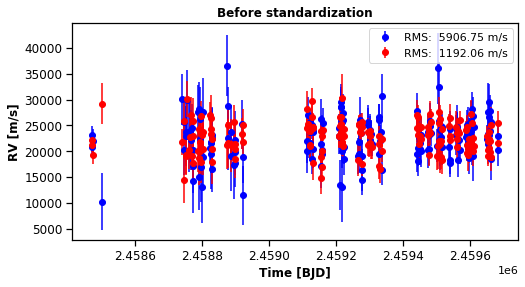

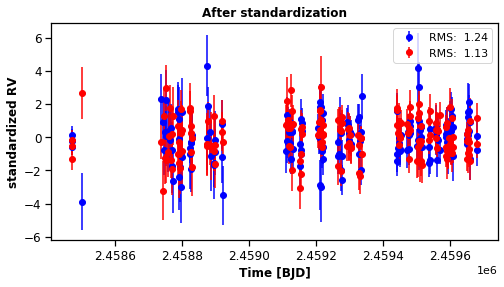

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.set_title('Before standardization', fontsize=12, weight='bold')
idx_max = np.argmax(np.nanstd(rvs_binned, axis=1))
idx_min = np.argmin(np.nanstd(rvs_binned, axis=1))

ax.errorbar(time_binned, rvs_binned[:, idx_max], drvs_binned[:, idx_max], fmt='bo', label = f'RMS: {np.max(np.nanstd(rvs_binned, axis=1)): .2f} m/s')
ax.errorbar(time_binned, rvs_binned[:, idx_min], drvs_binned[:, idx_min], fmt='ro', label = f'RMS: {np.min(np.nanstd(rvs_binned, axis=1)): .2f} m/s')
ax.legend()
ax.tick_params(labelsize=12)
ax.set_xlabel('Time [BJD]', fontsize=12, weight='bold')
ax.set_ylabel('RV [m/s]', fontsize=12, weight='bold')

fig, ax = plt.subplots(figsize=(8, 4))

ax.set_title('After standardization', fontsize=12, weight='bold')
idx_max = np.argmax(np.nanstd(rvs_binned, axis=1))
idx_min = np.argmin(np.nanstd(rvs_binned, axis=1))

ax.errorbar(time_binned, X[idx_max], dX[idx_max], fmt='bo', label = f'RMS: {np.nanstd(X[idx_max]): .2f}')
ax.errorbar(time_binned, X[idx_min], dX[idx_min], fmt='ro', label = f'RMS: {np.nanstd(X[idx_min]): .2f}')
ax.legend()
ax.tick_params(labelsize=12)
ax.set_xlabel('Time [BJD]', fontsize=12, weight='bold')
ax.set_ylabel('standardized RV', fontsize=12, weight='bold')

# $\texttt{Wapiti}$ step-by-step

$\texttt{Wapiti}$ (Weighted Principal Component Analysis Reconstruction) is a method utilized to eliminate the reconstruction made by wPCA from the per-line RV timeseries. To accomplish this, it is necessary to choose the appropriate number of components.

A common method to determine the appropriate number of components in a PCA is to inspect the explained variance ratio. The explained variance ratio measures the proportion of the total variance in the data that is explained by each component. By selecting the number of components that explains a certain level of the variance, such as 90\%, one can effectively reduce the number of components while still capturing a significant portion of the underlying variation in the data.

However, in our case, the explained variance ratio decreases very slowly, and 90\% of the variance is not reached until the 142$^{\rm nd}$ component out of 177. This is still too many components, and some of the variances may be noise rather than signal.

In [12]:
# Preprocessing steps
n_components = X.shape[1]

# Fit WPCA model
pca_0 = WPCA(n_components=n_components)
pca_0.regularization = 2  # Fix regularization at 2
pca_0.fit(X, weights=weights)

WPCA(n_components=177, regularization=2)

142 components are needed to explain 90% of the variance


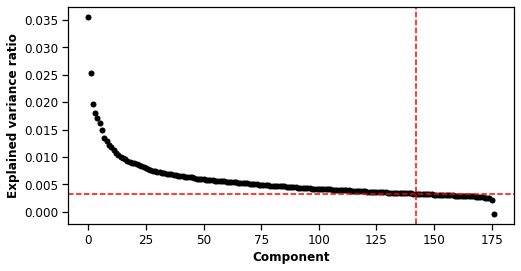

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
# Plot the explained variance ratio
ax.plot(pca_0.explained_variance_ratio_, 'ko', markersize=5)
# Calculate the number of components needed to explain 90% of the variance
k = 0
while np.sum(pca_0.explained_variance_ratio_[:k]) < 0.9:
    k += 1
print(f'{k} components are needed to explain 90% of the variance')
# Plot a horizontal and vertical line at the calculated number of components
ax.axhline(pca_0.explained_variance_ratio_[k], color='r', linestyle='--')

ax.axvline(k, color='r', linestyle='--')
# Set the y-label and x-label for the plot
ax.set_ylabel('Explained variance ratio', size=12, weight='bold')
ax.set_xlabel('Component', size=12, weight='bold')
# Set the font size for the tick labels on the first subplot
ax.tick_params(labelsize=12)

# Reducing the number of components through a permutation test

We use a permutation test to further reduce the number of components that we use. This test involves independently shuffling the columns of the dataset, and then conducting a wPCA on the resulting dataset. We repeat this process \textcolor{red}{100} times and compare the explained variance of the original dataset with the permuted versions. If a principal component is relevant, we expect that the permuted explained variances on that component will not be greater than the originally explained variance. We can identify the relevant components by examining the p-values and selecting those with low p-values ($\le 10^{-5}$).

In [14]:
p_val = wapiti.compute_p_values(X, weights)

  0%|          | 0/100 [00:00<?, ?it/s]

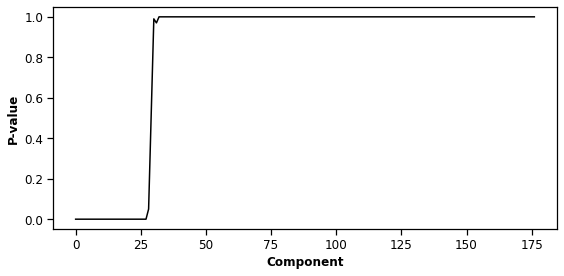

In [15]:
# Initialize a figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the p-value of the components
ax.plot(p_val, 'k-')
# Set the y-label and x-label for the plot
ax.set_ylabel('P-value', size=12, weight='bold')
ax.set_xlabel('Component', size=12, weight='bold')
# Set the font size for the tick labels on the first subplot
ax.tick_params(labelsize=12)
# Adjust the layout of the figure
plt.tight_layout()
# Display the figure
plt.show()
# Close the figure to free up memory
plt.close()

In [16]:
n_components = 0
while p_val[n_components] < 1e-5:
    n_components += 1
print(f'{n_components} components are retained after the permutation test.')

28 components are retained after the permutation test.


# Leave-p-out cross-validation

To evaluate the significance of the number of components retained after the permutation test, we conduct a leave-p-out cross-validation. We generate 100 subsets of the per-lines RV dataset, each containing 80\% of the lines randomly selected. The wPCA is then recalculated for each of these N datasets to assess the robustness of the remaining number of components.

In [17]:
pearson_array = wapiti.lpocv(X, weights, n_components)

  0%|          | 0/100 [00:00<?, ?it/s]

The mean Pearson coefficient value is calculated for each component number, and only those with a value above 95\% are retained.

In [18]:
pearson = np.nanmean(pearson_array, axis=1)

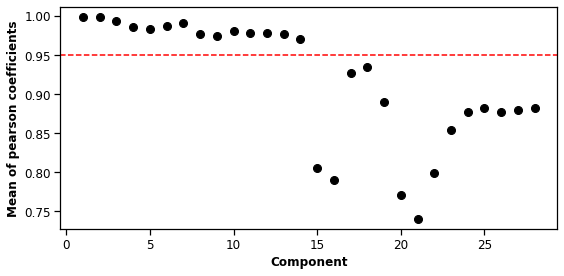

In [19]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.arange(1, len(pearson)+1), pearson, 'ko', markersize='8')
ax.axhline(0.95, linestyle='--',color='r')
ax.set_ylabel('Mean of pearson coefficients', size=12, weight='bold')
# Set the x-axis label
ax.set_xlabel('Component', size=12, weight='bold')
# Set the font size of the tick labels
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()

In [20]:
n_components = 0
while pearson[n_components] >= 0.95:
    n_components += 1
print(f'{n_components} components are retained after the leave-p out cross validation test.')

14 components are retained after the leave-p out cross validation test.


We can now conduct a wPCA using the number of components that were retained.

In [21]:
# Fit WPCA model
pca = WPCA(n_components=n_components)
pca.regularization = 2  # Fix regularization at 2
pca.fit(X, weights=weights)

WPCA(n_components=14, regularization=2)

Let us look at the principal vectors of the retained components 

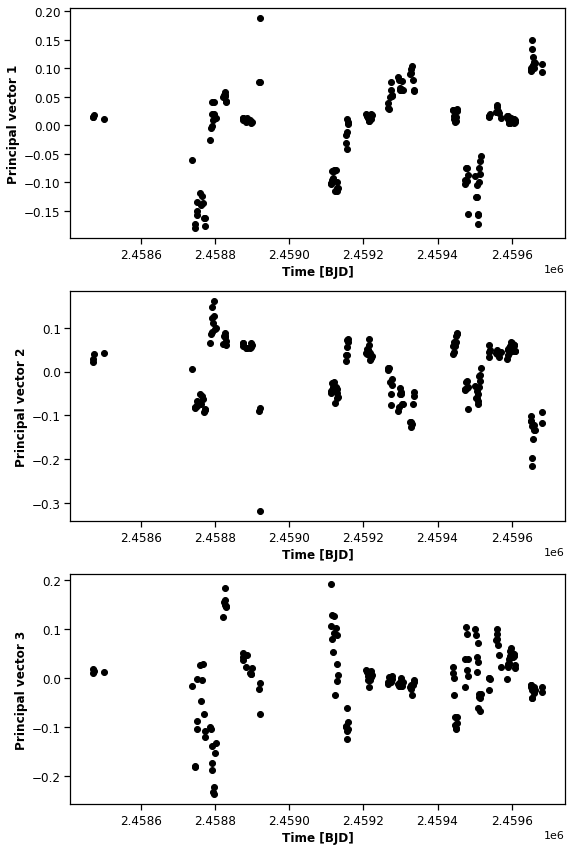

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

for n in range(3):
    
    ax[n].plot(time_binned, pca.components_[n], 'ko')
    
    ax[n].set_ylabel(f'Principal vector {n+1}', size=12, weight='bold')
    # Set the x-axis label
    ax[n].set_xlabel('Time [BJD]', size=12, weight='bold')
    # Set the font size of the tick labels
    ax[n].tick_params(labelsize=12)
plt.tight_layout()

We can utilize these components to perform the subtraction of the wPCA reconstruction from the LBL RV timeseries.

In [23]:
wpca_model = pca.reconstruct(X, weights=weights)
rvs_wapiti = (X - wpca_model)*std_X + mean_X
rvs_wapiti = rvs_wapiti.T

In [24]:
rv_0, std_rv_0 = [], []
for idx in tqdm(range(len(time_binned)), leave=False):
    rv_temp, std_rv_temp = wapiti_tools.odd_ratio_mean(rvs_binned[idx], drvs_binned[idx])
    rv_0.append(rv_temp)
    std_rv_0.append(std_rv_temp)
rv_0, std_rv_0 = np.array(rv_0), np.array(std_rv_0)

rv_wapiti, std_rv_wapiti = [], []
for idx in tqdm(range(len(time_binned)), leave=False):
    rv_temp, std_rv_temp = wapiti_tools.odd_ratio_mean(rvs_wapiti[idx], drvs_binned[idx])
    rv_wapiti.append(rv_temp)
    std_rv_wapiti.append(std_rv_temp)
rv_wapiti, std_rv_wapiti = np.array(rv_wapiti), np.array(std_rv_wapiti)

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

Original data: Maximum peak at  185.98 with a log FAP of -6.27
Wapiti corrected RV: Maximum peak at  14.25 with a log FAP of -3.55


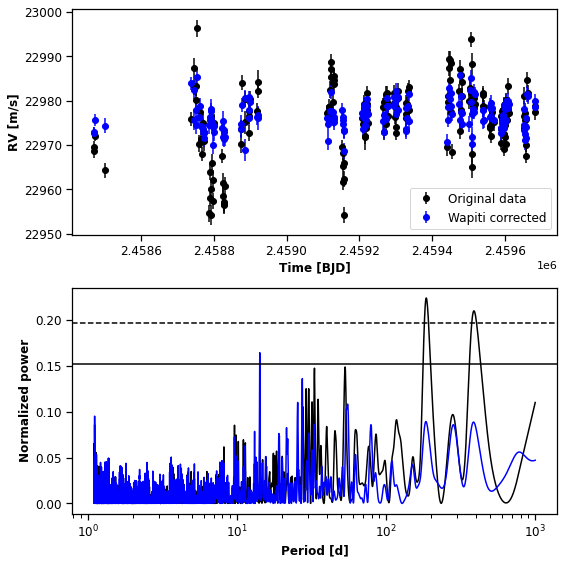

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].errorbar(time_binned, rv_0, std_rv_0, fmt='ko', label='Original data')
ax[0].errorbar(time_binned, rv_wapiti, std_rv_wapiti, fmt='bo', label='Wapiti corrected')

ls = LombScargle(time_binned, rv_0, std_rv_0)
power = ls.power(frequency)
ax[1].semilogx(1/frequency, power, 'k-')
fap = ls.false_alarm_probability(power.max())
print(f'Original data: Maximum peak at {1/frequency[np.argmax(power)]: .2f} with a log FAP of {np.log10(fap):.2f}')

ls = LombScargle(time_binned, rv_wapiti, std_rv_wapiti)
power = ls.power(frequency)
ax[1].semilogx(1/frequency, power, 'b-')
fap = ls.false_alarm_probability(power.max())
print(f'Wapiti corrected RV: Maximum peak at {1/frequency[np.argmax(power)]: .2f} with a log FAP of {np.log10(fap):.2f}')

# false alarm levels
fap = ls.false_alarm_level(1e-3)
ax[1].axhline(y=fap,linestyle="-",color="k")
fap = ls.false_alarm_level(1e-5)
ax[1].axhline(y=fap,linestyle="--",color="k")

ax[0].legend(fontsize=12)
ax[0].set_ylabel('RV [m/s]', size=12, weight='bold')
ax[0].set_xlabel('Time [BJD]', size=12, weight='bold')
ax[0].tick_params(labelsize=12)

ax[1].set_ylabel('Normalized power', size=12, weight='bold')
ax[1].set_xlabel('Period [d]', size=12, weight='bold')
ax[1].tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close() 

The $\texttt{Wapiti}$ method has successfully identified the 14.2 day period planet in our data. However, the signal is not really statistically significant. 

This could be due to short-term fluctuations that are not correlated with the most significant principal vectors, which have impacted the accuracy of the wPCA reconstruction.

To identify such anomalous observations, we compute for each epoch the maximum ratio between the absolute deviation ($AD$) and the median absolute deviation ($MAD$) among all principal vectors ($V_n$).

$$ D\left(t\right) = \max_{n} \frac{AD\left(V_n\left(t\right)\right)}{MAD\left(V_n\left(t\right)\right)} $$

In [26]:
D = wapiti_tools.compute_anomaly_degree(pca)

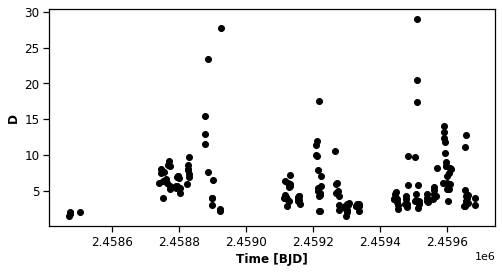

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(time_binned, D, 'ko')
ax.set_ylabel('D', size=12, weight='bold')
ax.set_xlabel('Time [BJD]', size=12, weight='bold')
ax.tick_params(labelsize=12)

Subsequently, we arrange the epochs in descending order of their corresponding $D$ value, and proceed to eliminate them one by one. We then recompute the wPCA on the remaining data points and we choose the most suitable number of epochs to reject that minimizes the log FAP of the $14.2$d signal.

In [28]:
faps = wapiti_tools.find_optimal_rejection(D, time_binned, rvs_binned, drvs_binned, frequency, n_components)

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

The signal is the most significant when removing the 23 observations of highest D with a log fap of -7.43


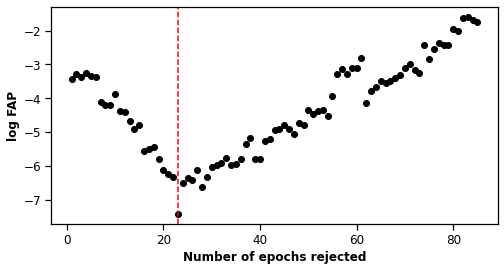

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(np.arange(1, faps.shape[0]+1), np.log10(faps), 'ko')
ax.axvline(np.argmin(faps)+1, linestyle='--', color='r')
ax.set_ylabel('log FAP', size=12, weight='bold')
ax.set_xlabel('Number of epochs rejected', size=12, weight='bold')
ax.tick_params(labelsize=12)
print(f'The signal is the most significant when removing the {np.argmin(faps)+1} observations of highest D with a log fap of {np.log10(np.min(faps)):.2f}')

In [30]:
index_sort = np.argsort(D)[::-1]
optimal_indx = np.argmin(faps)
time_used = np.delete(time_binned, index_sort[:optimal_indx+1])

# Mask the copies of the arrays using the mask
rvs_used = np.delete(np.copy(rvs_binned), index_sort[:optimal_indx+1], axis=0)
drvs_used = np.delete(np.copy(drvs_binned) , index_sort[:optimal_indx+1], axis=0)

# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_rvs = np.ma.MaskedArray((rvs_used.T), mask=np.isnan((rvs_used.T)))
ma_drvs = np.ma.MaskedArray((drvs_used.T), mask=np.isnan((drvs_used.T)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_rvs, weights=1/ma_drvs**2, axis=1)
variance = np.ma.average((ma_rvs-average.reshape(-1, 1))**2, weights=1/ma_drvs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_X = average.data.reshape(-1, 1)
std_X = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
X = (np.copy(rvs_used.T)-mean_X)/std_X
dX = np.copy(drvs_used.T)/std_X

# Compute weights for the RVs based on the normalized RV uncertainties
weights = 1. / dX
weights[np.isnan(X)] = 0 

pca = WPCA(n_components=n_components)
pca.regularization = 2
pca.fit(X, weights=weights)

WPCA(n_components=14, regularization=2)

In [31]:
wpca_model = pca.reconstruct(X, weights=weights)
rvs_wapiti = (X - wpca_model)*std_X + mean_X
rvs_wapiti = rvs_wapiti.T

In [32]:
rv_0, std_rv_0 = [], []
for idx in tqdm(range(len(time_used)), leave=False):
    rv_temp, std_rv_temp = wapiti_tools.odd_ratio_mean(rvs_used[idx], drvs_used[idx])
    rv_0.append(rv_temp)
    std_rv_0.append(std_rv_temp)
rv_0, std_rv_0 = np.array(rv_0), np.array(std_rv_0)

rv_wapiti, std_rv_wapiti = [], []
for idx in tqdm(range(len(time_used)), leave=False):
    rv_temp, std_rv_temp = wapiti_tools.odd_ratio_mean(rvs_wapiti[idx], drvs_used[idx])
    rv_wapiti.append(rv_temp)
    std_rv_wapiti.append(std_rv_temp)
rv_wapiti, std_rv_wapiti = np.array(rv_wapiti), np.array(std_rv_wapiti)

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

Original data: Maximum peak at  187.56 with a log FAP of -5.60
Wapiti corrected RV: Maximum peak at  14.26 with a log FAP of -7.43


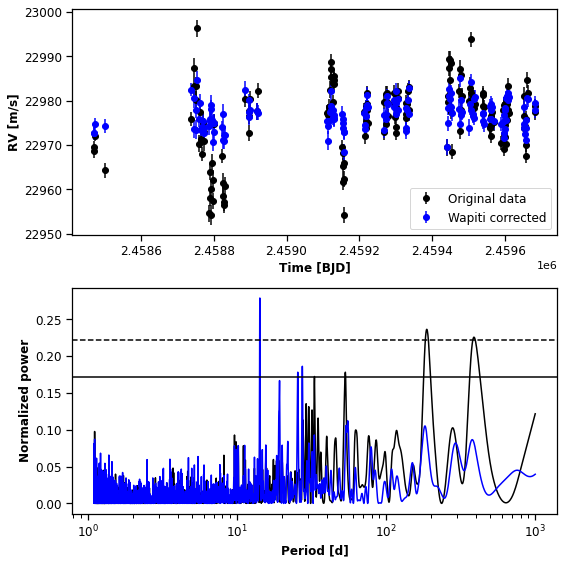

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].errorbar(time_used, rv_0, std_rv_0, fmt='ko', label='Original data')
ax[0].errorbar(time_used, rv_wapiti, std_rv_wapiti, fmt='bo', label='Wapiti corrected')

ls = LombScargle(time_used, rv_0, std_rv_0)
power = ls.power(frequency)
ax[1].semilogx(1/frequency, power, 'k-')
fap = ls.false_alarm_probability(power.max())
print(f'Original data: Maximum peak at {1/frequency[np.argmax(power)]: .2f} with a log FAP of {np.log10(fap):.2f}')

ls = LombScargle(time_used, rv_wapiti, std_rv_wapiti)
power = ls.power(frequency)
ax[1].semilogx(1/frequency, power, 'b-')
fap = ls.false_alarm_probability(power.max())
print(f'Wapiti corrected RV: Maximum peak at {1/frequency[np.argmax(power)]: .2f} with a log FAP of {np.log10(fap):.2f}')

# false alarm levels
fap = ls.false_alarm_level(1e-3)
ax[1].axhline(y=fap,linestyle="-",color="k")
fap = ls.false_alarm_level(1e-5)
ax[1].axhline(y=fap,linestyle="--",color="k")

ax[0].legend(fontsize=12)
ax[0].set_ylabel('RV [m/s]', size=12, weight='bold')
ax[0].set_xlabel('Time [BJD]', size=12, weight='bold')
ax[0].tick_params(labelsize=12)

ax[1].set_ylabel('Normalized power', size=12, weight='bold')
ax[1].set_xlabel('Period [d]', size=12, weight='bold')
ax[1].tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close() 

# Wapitify

The purpose of this tutorial was to illustrate the functionality of the $\texttt{Wapiti}$ tool. However, it is also feasible to apply the method directly by utilizing the $\texttt{wapitify}$ function.

In [34]:
from wapiti import wapitify

In [ ]:
time_wapiti, rv_wapiti, std_rv_wapiti = wapitify.wapitify(time_binned, rvs_binned, drvs_binned)